<a href="https://colab.research.google.com/github/adventurousAyan/MLAppB81A/blob/main/Final_Hack_3671_Ayan_Jana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, recall_score,confusion_matrix, precision_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
import seaborn as sns
%matplotlib inline

In [95]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/traindata_without_target.csv")

In [96]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

In [97]:
data.dtypes

date               datetime64[ns]
farm_id                    object
ingredient_type            object
dtype: object

In [98]:
data.set_index('date', inplace=True)

In [99]:
data.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               '2016-01-01 00:00:00', '2016-01-01 00:00:00',
               ...
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00',
               '2016-12-31 23:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date', length=20216100, freq=None)

In [100]:
data.groupby(pd.Grouper(freq="W")) 

In [101]:
df = data.groupby(pd.Grouper(freq="W"))

In [102]:
pd.set_option('display.max_rows', None)

In [103]:
class CustomEDA:     
    """Custom Exploratory Data Analysis Class"""    
    
    def fn_nulls_count(self, df):
        """Function to count the null values and their percentages in each column."""
        # Nulls counts in each column.
        nulls_counts = df.isnull().sum()
        # Convert above series into dataframe.
        nulls_counts_df = nulls_counts.to_frame(name = 'nulls_count')
        # Add a new column - to get the null counts percentage to the total rows.
        nulls_counts_df['nulls_percentage'] = round(100 * nulls_counts_df['nulls_count']/df.shape[0], 2)
        # Return the null counts dataframe.
        return nulls_counts_df
    
    def fn_plot_residuals(self, df):
        """Function to plot residuals in data."""
        # retrieve data as numpy array
        values = df.values
        print(values.shape)
        # create a subplot for each time series
        plt.figure(figsize=(16, 16))
        for i in range(values.shape[1]):
            plt.subplot(values.shape[1], 1, i+1)
            plt.plot(values[:, i])
        plt.show()
    
    
    def fn_compute_outliers(self, df):
        """Function to check for outliers in data."""
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        cleaned_eeg_df = df[~((df < (Q1 - 1.5 * IQR)) |
                                  (df > (Q3 + 1.5 * IQR)))\
                                .any(axis=1)]
        print(cleaned_eeg_df.shape)
    
    
    def fn_plot_correlation(self, df):
        """Function to plot the correlation in data."""
        plt.figure(figsize=(12,7))
        sns.heatmap(df.corr(), annot=True)
        plt.xticks(rotation=45)
        plt.show()
    
    def fn_check_and_drop_duplicates(self, df):
        """Function to check and drop duplicates in data."""
        duplicate = df[df.duplicated()]  
        print("Duplicate Rows :")  
        #Print the resultant Dataframe 
        duplicate 
        df_duplicates_removed = pd.DataFrame.drop_duplicates(df)
        print(df_duplicates_removed)
        return df_duplicates_removed

    def fn_compute_metrics(self, model, x_train, x_test, y_train, y_test, iter_no, model_name):
        """Function to compute metrics after the model has been built. 
           Takes model_name as in input parameter to store results of various models 
           Uses a dataframe metric_data to store the results of various runs across various ML models
        """
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        print(model.score(x_train, y_train))
        print(model.score(x_test, y_test))
        print("\n")
        confusion_matrix_train = confusion_matrix(y_true=y_train, y_pred = train_pred)
        confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)
        print(confusion_matrix_train)   
        print(confusion_matrix_test)   

        f1 = f1_score(y_train,train_pred)
        recall = recall_score(y_train,train_pred)
        accuracy = accuracy_score(y_train,train_pred)
        prec = precision_score(y_train, train_pred)
        metric_data.loc[metric_data.shape[0]] = [iter_no,model_name,'Train',accuracy,f1,recall, prec] 

        f1_test = f1_score(y_test,test_pred)
        rc_test = recall_score(y_test,test_pred)
        ac_test = accuracy_score(y_test,test_pred)
        prec_test = precision_score(y_test, test_pred)
        metric_data.loc[metric_data.shape[0]] = [iter_no,model_name,'Test',ac_test,f1_test,rc_test, prec_test] 
        print(classification_report(y_train,train_pred))
    
    def fn_set_up_metric_data(self):
        """Intialiazes the metric_data to store result of various runs"""
        metric_data = pd.DataFrame(columns = ['Iteration No', 'Model Name','Method Type','Accuracy Score','F1 score','Recall Score', 'Precision Score'])
        return metric_data
    
    def fn_fetch_col_based_ontype(self, df, *args):
        """Function to return column based on column type"""
        return df.select_dtypes(include=args).columns.tolist()
    
    def fn_get_data_information(self, df):
        """Function to fetch data-frame information"""
        print(f'Shape of dataframe is {df.shape}')
        print('*************************************************************')
        print("DataFrame information")
        print(df.info())
        print('************************************************************')
        print("DataFrame Summary")
        print(df.describe())
        
    def fn_plot_pairplots(self, df, targetCol):
        for i in range(0, len(df.columns), 5):
                sns.pairplot(data=df,
                x_vars=df.columns[i:i+5],
                y_vars=[targetCol])
                
    def fn_plot_regplot(self, df, features_to_analyse, targetCol):
        fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))
        for i, ax in enumerate(fig.axes):
            if i < len(features_to_analyse) - 1:
                sns.regplot(x=features_to_analyse[i],y=targetCol, data=df[features_to_analyse], ax=ax)
                
    def fn_plot_countplot(self, df_not_num):
        fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))
        for i, ax in enumerate(fig.axes):
            if i < len(df_not_num.columns):
                ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
                sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)
        fig.tight_layout() 
    
    def fn_plot_histplot(self, df_num):
        df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
        
    def fn_nulls_plot(self,df):
        plt.figure(figsize = (12,6))
        sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
        plt.xticks(rotation=45)
        plt.show()

In [104]:
farm_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/farm_data.csv")
weather_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/train_weather.csv")

In [105]:
print(data.shape)
print("*"*25)
print(farm_data.shape)
print("*"*25)
print(weather_data.shape)

(20216100, 2)
*************************
(1449, 6)
*************************
(139773, 9)


In [106]:
data.head()

farm_id ingredient_type
date                                  
2016-01-01  fid_110884           ing_w
2016-01-01   fid_90053           ing_w
2016-01-01   fid_17537           ing_w
2016-01-01  fid_110392           ing_w
2016-01-01   fid_62402           ing_w

In [107]:
data.tail()

farm_id ingredient_type
date                                          
2016-12-31 23:00:00  fid_41664           ing_w
2016-12-31 23:00:00  fid_14529           ing_w
2016-12-31 23:00:00  fid_46454           ing_w
2016-12-31 23:00:00  fid_24103           ing_w
2016-12-31 23:00:00  fid_34139           ing_w

In [108]:
data.nunique()

farm_id            1434
ingredient_type       4
dtype: int64

In [109]:
data['ingredient_type'].unique()

array(['ing_w', 'ing_z', 'ing_x', 'ing_y'], dtype=object)

In [110]:
farm_data.head()

farm_id  operations_commencing_year  ...  farming_company  deidentified_location
0  fid_110884                      2008.0  ...      Obery Farms          location 7369
1   fid_90053                      2004.0  ...      Obery Farms          location 7369
2   fid_17537                      1991.0  ...      Obery Farms          location 7369
3  fid_110392                      2002.0  ...      Obery Farms          location 7369
4   fid_62402                      1975.0  ...      Obery Farms          location 7369

[5 rows x 6 columns]

In [111]:
farm_data.tail()

farm_id  ...  deidentified_location
1444  fid_41664  ...          location 5150
1445  fid_14529  ...          location 5150
1446  fid_46454  ...          location 5150
1447  fid_24103  ...          location 5150
1448  fid_34139  ...          location 5150

[5 rows x 6 columns]

In [112]:
farm_data.nunique()

farm_id                       1434
operations_commencing_year     116
num_processing_plants           18
farm_area                     1397
farming_company                 16
deidentified_location           16
dtype: int64

In [113]:
farm_data.dtypes

farm_id                        object
operations_commencing_year    float64
num_processing_plants         float64
farm_area                     float64
farming_company                object
deidentified_location          object
dtype: object

In [114]:
weather_data.head()

timestamp deidentified_location  ...  precipitation  wind_speed
0  2016-01-01 00:00:00         location 7369  ...            NaN         0.0
1  2016-01-01 01:00:00         location 7369  ...           -1.0         1.5
2  2016-01-01 02:00:00         location 7369  ...            0.0         0.0
3  2016-01-01 03:00:00         location 7369  ...            0.0         0.0
4  2016-01-01 04:00:00         location 7369  ...           -1.0         2.6

[5 rows x 9 columns]

In [115]:
weather_data.tail()

timestamp deidentified_location  ...  precipitation  wind_speed
139768  2016-12-31 19:00:00         location 5150  ...            NaN         5.7
139769  2016-12-31 20:00:00         location 5150  ...            NaN         7.7
139770  2016-12-31 21:00:00         location 5150  ...            NaN         5.1
139771  2016-12-31 22:00:00         location 5150  ...            NaN         4.6
139772  2016-12-31 23:00:00         location 5150  ...           -1.0         8.8

[5 rows x 9 columns]

In [116]:
weather_data.nunique()

timestamp                8784
deidentified_location      16
temp_obs                  619
cloudiness                 10
wind_direction             43
dew_temp                  522
pressure_sea_level        709
precipitation             128
wind_speed                 58
dtype: int64

In [117]:
weather_data.dtypes

timestamp                 object
deidentified_location     object
temp_obs                 float64
cloudiness               float64
wind_direction           float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
dtype: object

In [118]:
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'], format='%Y-%m-%d %H:%M:%S')
weather_data['timestamp'] = weather_data['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [119]:
weather_data['timestamp'].unique()

array(['2016-01-01T00:00:00.000000000', '2016-01-01T01:00:00.000000000',
       '2016-01-01T02:00:00.000000000', ...,
       '2016-12-31T21:00:00.000000000', '2016-12-31T22:00:00.000000000',
       '2016-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [120]:
weather_data['Month'] = weather_data['timestamp'].dt.month

In [121]:
weather_data.drop('timestamp', axis=1, inplace=True)

In [122]:
weather_data.head()

deidentified_location  temp_obs  cloudiness  ...  precipitation  wind_speed  Month
0         location 7369      25.0         6.0  ...            NaN         0.0      1
1         location 7369      24.4         NaN  ...           -1.0         1.5      1
2         location 7369      22.8         2.0  ...            0.0         0.0      1
3         location 7369      21.1         2.0  ...            0.0         0.0      1
4         location 7369      20.0         2.0  ...           -1.0         2.6      1

[5 rows x 9 columns]

In [123]:
# Convert few columns to categories
col_to_be_converted = ['farm_id', 'operations_commencing_year','farming_company','deidentified_location']
farm_data[col_to_be_converted] = farm_data[col_to_be_converted].astype('category')
farm_data.dtypes

farm_id                       category
operations_commencing_year    category
num_processing_plants          float64
farm_area                      float64
farming_company               category
deidentified_location         category
dtype: object

In [124]:
df = pd.merge(data, farm_data, on="farm_id")

In [125]:
df.head()

farm_id ingredient_type  ... farming_company  deidentified_location
0  fid_110884           ing_w  ...     Obery Farms          location 7369
1  fid_110884           ing_w  ...     Obery Farms          location 7369
2  fid_110884           ing_w  ...     Obery Farms          location 7369
3  fid_110884           ing_w  ...     Obery Farms          location 7369
4  fid_110884           ing_w  ...     Obery Farms          location 7369

[5 rows x 7 columns]

In [126]:
df['farm_id'].nunique()


1434

In [127]:

df['deidentified_location'].nunique()



16

In [128]:
df[df.farm_id == 'fid_110884'].deidentified_location.unique()


['location 7369']
Categories (1, object): ['location 7369']

In [129]:

df[df.deidentified_location == 'location 7369'].farm_id.unique()

array(['fid_110884', 'fid_90053', 'fid_17537', 'fid_110392', 'fid_62402',
       'fid_121604', 'fid_85694', 'fid_33785', 'fid_110793', 'fid_32954',
       'fid_61445', 'fid_20096', 'fid_56102', 'fid_43573', 'fid_48575',
       'fid_109906', 'fid_34103', 'fid_57758', 'fid_48075', 'fid_64013',
       'fid_76740', 'fid_20789', 'fid_32291', 'fid_115413', 'fid_69590',
       'fid_100807', 'fid_105085', 'fid_44304', 'fid_102416', 'fid_29482',
       'fid_38448', 'fid_56855', 'fid_63385', 'fid_46223', 'fid_116934',
       'fid_111680', 'fid_49528', 'fid_15951', 'fid_120178', 'fid_80442',
       'fid_74101', 'fid_76042', 'fid_107841', 'fid_70417', 'fid_110278',
       'fid_51884', 'fid_12776', 'fid_94807', 'fid_87168', 'fid_112127',
       'fid_28622', 'fid_73322', 'fid_111986', 'fid_57916', 'fid_68605',
       'fid_88913', 'fid_119338', 'fid_46725', 'fid_97363', 'fid_14189',
       'fid_21897', 'fid_47782', 'fid_107436', 'fid_107874', 'fid_40459',
       'fid_12360', 'fid_105593', 'fid_24658'

In [130]:
weather_data.shape

(139773, 9)

In [131]:
weather_data.columns

Index(['deidentified_location', 'temp_obs', 'cloudiness', 'wind_direction',
       'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed',
       'Month'],
      dtype='object')

In [132]:
#df2 = pd.merge(df, weather_data, on="deidentified_location")
df_weather = weather_data.groupby(['Month','deidentified_location'])\
.agg({'temp_obs':np.mean,'cloudiness':np.mean, 'dew_temp': np.mean, 'pressure_sea_level':np.mean, 'precipitation': np.mean, 'wind_speed':np.mean})

df_weather.reset_index()


Month deidentified_location  ...  precipitation  wind_speed
0        1         location 1784  ...       0.638327    2.292463
1        1         location 2532  ...      -0.032345    4.006317
2        1         location 4525  ...       3.896104    3.517784
3        1         location 5150  ...      -0.098214    4.460968
4        1         location 5290  ...       0.780619    4.234812
5        1         location 5410  ...       0.471063    3.421265
6        1         location 5489  ...       0.362162    2.287903
7        1          location 565  ...       0.593540    2.428129
8        1         location 5677  ...       1.796770    3.642876
9        1         location 5833  ...       0.595136    3.252355
10       1         location 6364  ...            NaN    5.594879
11       1         location 7048  ...            NaN    6.866801
12       1         location 7369  ...       1.796770    3.642876
13       1         location 8421  ...       0.081522    1.847043
14       1          location 868  ...       3.896104    3.517784
15       1          location 959  ...            NaN    5.013710
16       2         location 1784  ...       0.196839    2.734052
17       2         location 2532  ...       0.134199    4.450862
18       2         location 4525  ...       7.095745    4.206354
19       2         location 5150  ...       2.887967    4.532018
20       2         location 5290  ...       0.936782    4.536547
21       2         location 5410  ...       1.102941    3.712069
22       2         location 5489  ...       0.063218    2.616092
23       2          location 565  ...       1.458333    2.790230
24       2         location 5677  ...       0.593391    4.054741
25       2         location 5833  ...       0.027417    2.786207
26       2         location 6364  ...            NaN    5.880848
27       2         location 7048  ...            NaN    6.930321
28       2         location 7369  ...       0.593391    4.054741
29       2         location 8421  ...       0.285920    2.480580
30       2          location 868  ...       7.095745    4.206354
31       2          location 959  ...            NaN    5.209489
32       3         location 1784  ...       0.556452    3.242568
33       3         location 2532  ...       0.540027    4.301750
34       3         location 4525  ...      11.064103    3.334078
35       3         location 5150  ...       1.566176    4.040669
36       3         location 5290  ...       0.291667    4.349866
37       3         location 5410  ...       0.465054    3.691655
38       3         location 5489  ...       0.000000    2.954032
39       3          location 565  ...       0.348118    3.036572
40       3         location 5677  ...       1.740591    3.633602
41       3         location 5833  ...       0.490228    4.314247
42       3         location 6364  ...            NaN    4.990599
43       3         location 7048  ...            NaN    5.623497
44       3         location 7369  ...       1.740591    3.633602
45       3         location 8421  ...       1.008065    2.734146
46       3          location 868  ...      11.064103    3.334078
47       3          location 959  ...            NaN    4.241949
48       4         location 1784  ...       0.670833    3.663866
49       4         location 2532  ...       0.856944    5.251111
50       4         location 4525  ...       9.530612    3.564993
51       4         location 5150  ...       1.856287    3.509517
52       4         location 5290  ...       0.523611    4.563889
53       4         location 5410  ...       0.459722    3.432962
54       4         location 5489  ...       0.166667    3.305417
55       4          location 565  ...       1.015278    3.037781
56       4         location 5677  ...       0.197222    3.759306
57       4         location 5833  ...      -0.047170    4.389861
58       4         location 6364  ...            NaN    4.879833
59       4         location 7048  ...            NaN    5.612796
60       4         location 7369  ...   

In [133]:
df_weather.shape

(192, 6)

In [134]:
df_weather.isnull().sum()

temp_obs               0
cloudiness            24
dew_temp               0
pressure_sea_level    12
precipitation         36
wind_speed             0
dtype: int64

In [135]:
df_weather.dtypes

temp_obs              float64
cloudiness            float64
dew_temp              float64
pressure_sea_level    float64
precipitation         float64
wind_speed            float64
dtype: object

In [136]:
df_weather.columns

Index(['temp_obs', 'cloudiness', 'dew_temp', 'pressure_sea_level',
       'precipitation', 'wind_speed'],
      dtype='object')

In [137]:
df_weather.reset_index(inplace=True)

In [138]:
df_weather.dtypes

Month                      int64
deidentified_location     object
temp_obs                 float64
cloudiness               float64
dew_temp                 float64
pressure_sea_level       float64
precipitation            float64
wind_speed               float64
dtype: object

In [139]:
df_weather.head()

Month deidentified_location  ...  precipitation  wind_speed
0      1         location 1784  ...       0.638327    2.292463
1      1         location 2532  ...      -0.032345    4.006317
2      1         location 4525  ...       3.896104    3.517784
3      1         location 5150  ...      -0.098214    4.460968
4      1         location 5290  ...       0.780619    4.234812

[5 rows x 8 columns]

In [140]:
df_weather.nunique()

Month                     12
deidentified_location     16
temp_obs                 168
cloudiness               145
dew_temp                 168
pressure_sea_level       156
precipitation            129
wind_speed               168
dtype: int64

In [141]:
df_weather.describe()

Month    temp_obs  ...  precipitation  wind_speed
count  192.000000  192.000000  ...     156.000000  192.000000
mean     6.500000   14.336759  ...       3.170524    3.562183
std      3.461078    9.498288  ...       6.236885    0.991558
min      1.000000   -7.868414  ...      -0.098214    1.529364
25%      3.750000    6.968683  ...       0.340876    2.952052
50%      6.500000   15.101964  ...       0.787487    3.507079
75%      9.250000   21.695161  ...       1.831780    4.155138
max     12.000000   36.389098  ...      31.418605    6.930321

[8 rows x 7 columns]

In [142]:
eda = CustomEDA()

In [143]:
eda.fn_nulls_count(df_weather)

nulls_count  nulls_percentage
Month                            0              0.00
deidentified_location            0              0.00
temp_obs                         0              0.00
cloudiness                      24             12.50
dew_temp                         0              0.00
pressure_sea_level              12              6.25
precipitation                   36             18.75
wind_speed                       0              0.00

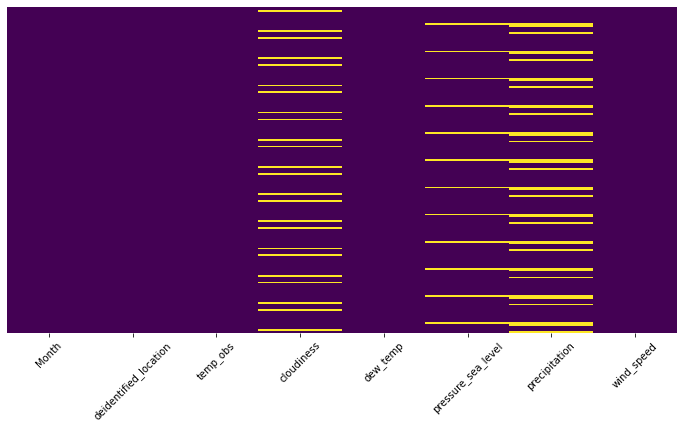

In [144]:
eda.fn_nulls_plot(df_weather)

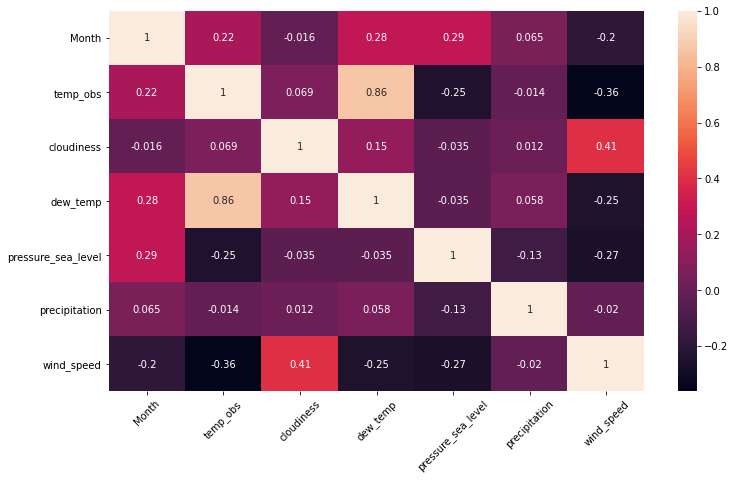

In [145]:
eda.fn_plot_correlation(df_weather)

In [146]:
df_weather.head()

Month deidentified_location  ...  precipitation  wind_speed
0      1         location 1784  ...       0.638327    2.292463
1      1         location 2532  ...      -0.032345    4.006317
2      1         location 4525  ...       3.896104    3.517784
3      1         location 5150  ...      -0.098214    4.460968
4      1         location 5290  ...       0.780619    4.234812

[5 rows x 8 columns]

In [147]:
df_weather.drop('temp_obs', axis=1, inplace=True)

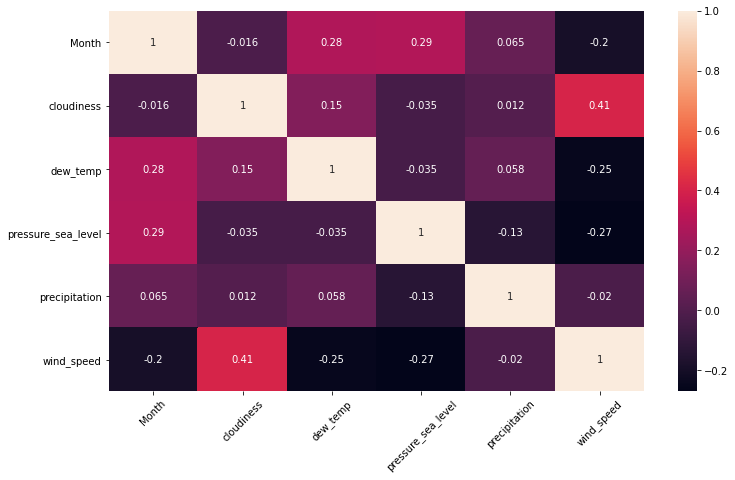

In [148]:
eda.fn_plot_correlation(df_weather)

In [149]:
imputer = SimpleImputer(missing_values='NaN', strategy='median')


In [150]:
df_weather.head()

Month deidentified_location  ...  precipitation  wind_speed
0      1         location 1784  ...       0.638327    2.292463
1      1         location 2532  ...      -0.032345    4.006317
2      1         location 4525  ...       3.896104    3.517784
3      1         location 5150  ...      -0.098214    4.460968
4      1         location 5290  ...       0.780619    4.234812

[5 rows x 7 columns]

In [151]:
num_cols = eda.fn_fetch_col_based_ontype(df_weather, 'float64')

In [152]:
num_cols

['cloudiness', 'dew_temp', 'pressure_sea_level', 'precipitation', 'wind_speed']

In [153]:
df_weather['cloudiness'].fillna(df_weather['cloudiness'].mean(), inplace = True)

In [154]:
df_weather['precipitation'].fillna(df_weather['precipitation'].mean(), inplace = True)
df_weather['pressure_sea_level'].fillna(df_weather['pressure_sea_level'].mean(), inplace = True)

In [155]:
eda.fn_nulls_count(df_weather)

nulls_count  nulls_percentage
Month                            0               0.0
deidentified_location            0               0.0
cloudiness                       0               0.0
dew_temp                         0               0.0
pressure_sea_level               0               0.0
precipitation                    0               0.0
wind_speed                       0               0.0

In [156]:
df_weather.head()

Month deidentified_location  ...  precipitation  wind_speed
0      1         location 1784  ...       0.638327    2.292463
1      1         location 2532  ...      -0.032345    4.006317
2      1         location 4525  ...       3.896104    3.517784
3      1         location 5150  ...      -0.098214    4.460968
4      1         location 5290  ...       0.780619    4.234812

[5 rows x 7 columns]

In [157]:
data.head()

farm_id ingredient_type
date                                  
2016-01-01  fid_110884           ing_w
2016-01-01   fid_90053           ing_w
2016-01-01   fid_17537           ing_w
2016-01-01  fid_110392           ing_w
2016-01-01   fid_62402           ing_w

In [158]:
#data.reset_index(inplace=True)

In [159]:
#data['date_part'] = data['date'].dt.date

In [160]:
#data.drop('date', axis=1, inplace=True)

In [161]:
data.head()

farm_id ingredient_type
date                                  
2016-01-01  fid_110884           ing_w
2016-01-01   fid_90053           ing_w
2016-01-01   fid_17537           ing_w
2016-01-01  fid_110392           ing_w
2016-01-01   fid_62402           ing_w

In [162]:
#data['date'] = data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_merge_farm_train = pd.merge(data, farm_data, on="farm_id")

In [163]:
df_merge_farm_train.head()

farm_id ingredient_type  ... farming_company  deidentified_location
0  fid_110884           ing_w  ...     Obery Farms          location 7369
1  fid_110884           ing_w  ...     Obery Farms          location 7369
2  fid_110884           ing_w  ...     Obery Farms          location 7369
3  fid_110884           ing_w  ...     Obery Farms          location 7369
4  fid_110884           ing_w  ...     Obery Farms          location 7369

[5 rows x 7 columns]

In [164]:
df_merge_farm_train.tail()

farm_id ingredient_type  ... farming_company  deidentified_location
20602894  fid_19864           ing_w  ...     Obery Farms          location 5290
20602895  fid_19864           ing_w  ...     Obery Farms          location 5290
20602896  fid_19864           ing_w  ...     Obery Farms          location 5290
20602897  fid_19864           ing_w  ...     Obery Farms          location 5290
20602898  fid_19864           ing_w  ...     Obery Farms          location 5290

[5 rows x 7 columns]

In [165]:
df_merge_farm_train.nunique()

farm_id                       1434
ingredient_type                  4
operations_commencing_year     116
num_processing_plants           18
farm_area                     1397
farming_company                 16
deidentified_location           16
dtype: int64

In [166]:
weather_data.nunique()

deidentified_location     16
temp_obs                 619
cloudiness                10
wind_direction            43
dew_temp                 522
pressure_sea_level       709
precipitation            128
wind_speed                58
Month                     12
dtype: int64

In [167]:
#len(df_weather[df_weather.deidentified_location == 'location 1784'].date_timestamp)

In [168]:
#len(df_merge_farm_train[df_merge_farm_train.deidentified_location == 'location 1784'].date_part)

In [169]:
df_merge_farm_train.dtypes

farm_id                         object
ingredient_type                 object
operations_commencing_year    category
num_processing_plants          float64
farm_area                      float64
farming_company               category
deidentified_location         category
dtype: object

In [170]:
df_merge_farm_train.head()

farm_id ingredient_type  ... farming_company  deidentified_location
0  fid_110884           ing_w  ...     Obery Farms          location 7369
1  fid_110884           ing_w  ...     Obery Farms          location 7369
2  fid_110884           ing_w  ...     Obery Farms          location 7369
3  fid_110884           ing_w  ...     Obery Farms          location 7369
4  fid_110884           ing_w  ...     Obery Farms          location 7369

[5 rows x 7 columns]

In [171]:
#df3 = df_merge_farm_train.groupby(['date_part', 'farm_id']).\
#agg({'farm_area':np.mean}).reset_index()

In [172]:
#df3.head()

In [173]:
eda.fn_nulls_count(df_merge_farm_train)

nulls_count  nulls_percentage
farm_id                               0              0.00
ingredient_type                       0              0.00
operations_commencing_year     12351033             59.95
num_processing_plants          16995234             82.49
farm_area                             0              0.00
farming_company                       0              0.00
deidentified_location                 0              0.00

In [174]:
df_merge_farm_train.shape

(20602899, 7)

In [175]:
df_merge_farm_train.drop(['operations_commencing_year', 'num_processing_plants'], axis=1, inplace=True)

In [176]:
eda.fn_nulls_count(df_merge_farm_train)

nulls_count  nulls_percentage
farm_id                          0               0.0
ingredient_type                  0               0.0
farm_area                        0               0.0
farming_company                  0               0.0
deidentified_location            0               0.0

In [177]:
df_weather.shape

(192, 7)

In [178]:
df_weather.head()

Month deidentified_location  ...  precipitation  wind_speed
0      1         location 1784  ...       0.638327    2.292463
1      1         location 2532  ...      -0.032345    4.006317
2      1         location 4525  ...       3.896104    3.517784
3      1         location 5150  ...      -0.098214    4.460968
4      1         location 5290  ...       0.780619    4.234812

[5 rows x 7 columns]

In [179]:
df_weather.nunique()

Month                     12
deidentified_location     16
cloudiness               146
dew_temp                 168
pressure_sea_level       157
precipitation            130
wind_speed               168
dtype: int64

In [180]:
df_merge_farm_train.head()

farm_id ingredient_type   farm_area farming_company deidentified_location
0  fid_110884           ing_w  690.455096     Obery Farms         location 7369
1  fid_110884           ing_w  690.455096     Obery Farms         location 7369
2  fid_110884           ing_w  690.455096     Obery Farms         location 7369
3  fid_110884           ing_w  690.455096     Obery Farms         location 7369
4  fid_110884           ing_w  690.455096     Obery Farms         location 7369

In [181]:
df_temp = eda.fn_check_and_drop_duplicates(df_merge_farm_train)

Duplicate Rows :
             farm_id  ... deidentified_location
0         fid_110884  ...         location 7369
8784       fid_90053  ...         location 7369
17568      fid_17537  ...         location 7369
26352     fid_110392  ...         location 7369
35136      fid_62402  ...         location 7369
43920     fid_121604  ...         location 7369
52704      fid_85694  ...         location 7369
61488      fid_33785  ...         location 7369
62914      fid_33785  ...         location 7369
77539     fid_110793  ...         location 7369
86323      fid_32954  ...         location 7369
87749      fid_32954  ...         location 7369
102372     fid_61445  ...         location 7369
111156     fid_20096  ...         location 7369
119940     fid_56102  ...         location 7369
128724     fid_43573  ...         location 7369
130150     fid_43573  ...         location 7369
144448     fid_48575  ...         location 7369
145874     fid_48575  ...         location 7369
160501    fid_109906  .

In [182]:
df_temp.shape

(2392, 5)

In [183]:
df_temp.reset_index(inplace=True)

In [184]:
df_temp.drop('index', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [185]:
df_temp.head(50)

farm_id ingredient_type  ...    farming_company deidentified_location
0   fid_110884           ing_w  ...        Obery Farms         location 7369
1    fid_90053           ing_w  ...        Obery Farms         location 7369
2    fid_17537           ing_w  ...        Obery Farms         location 7369
3   fid_110392           ing_w  ...        Obery Farms         location 7369
4    fid_62402           ing_w  ...        Obery Farms         location 7369
5   fid_121604           ing_w  ...        Obery Farms         location 7369
6    fid_85694           ing_w  ...  Dole Food Company         location 7369
7    fid_33785           ing_w  ...        Obery Farms         location 7369
8    fid_33785           ing_x  ...        Obery Farms         location 7369
9   fid_110793           ing_w  ...        Obery Farms         location 7369
10   fid_32954           ing_w  ...        Wayne Farms         location 7369
11   fid_32954           ing_x  ...        Wayne Farms         location 7369
12   fid_61445           ing_w  ...    Sanderson Farms         location 7369
13   fid_20096           ing_w  ...        Obery Farms         location 7369
14   fid_56102           ing_w  ...  Dole Food Company         location 7369
15   fid_43573           ing_w  ...        Obery Farms         location 7369
16   fid_43573           ing_x  ...        Obery Farms         location 7369
17   fid_48575           ing_w  ...        Obery Farms         location 7369
18   fid_48575           ing_x  ...        Obery Farms         location 7369
19  fid_109906           ing_w  ...        Wayne Farms         location 7369
20  fid_109906           ing_x  ...        Wayne Farms         location 7369
21   fid_34103           ing_w  ...        Obery Farms         location 7369
22   fid_57758           ing_w  ...        Wayne Farms         location 7369
23   fid_48075           ing_w  ...        Obery Farms         location 7369
24   fid_64013           ing_w  ...        Wayne Farms         location 7369
25   fid_76740           ing_w  ...        Obery Farms         location 7369
26   fid_20789           ing_w  ...        Wayne Farms         location 7369
27   fid_32291           ing_w  ...        Obery Farms         location 7369
28  fid_115413           ing_w  ...        Obery Farms         location 7369
29   fid_69590           ing_w  ...        Obery Farms         location 7369
30  fid_100807           ing_w  ...        Wayne Farms         location 7369
31  fid_105085           ing_w  ...        Wayne Farms         location 7369
32   fid_44304           ing_w  ...  Dole Food Company         location 7369
33  fid_102416           ing_w  ...        Wayne Farms         location 7369
34  fid_102416           ing_x  ...        Wayne Farms         location 7369
35   fid_29482           ing_w  ...        Obery Farms         location 7369
36   fid_29482           ing_x  ...        Obery Farms         location 7369
37   fid_38448           ing_w  ...        Obery Farms         location 7369
38   fid_38448           ing_x  ...        Obery Farms         location 7369
39   fid_56855           ing_w  ...        Wayne Farms         location 7369
40   fid_63385           ing_w  ...  Dole Food Company         location 7369
41   fid_46223           ing_w  ...  Dole Food Company         location 7369
42  fid_116934           ing_w  ...  Dole Food Company         location 7369
43  fid_111680           ing_w  ...  Dole Food Company         location 7369
44   fid_49528           ing_w  ...  Dole Food Company         location 7369
45   fid_15951           ing_w  ...        Wayne Farms         location 7369
46  fid_120178           ing_w  ...        Wayne Farms         location 7369
47   fid_80442           ing_w  ...    Sanderson Farms         location 7369
48   fid_74101           ing_w  ...        Wayne Farms         location 7369
49   fid_76042           ing_w  ...              Other         location 7369

[50 rows x 5 columns]

In [186]:
#df_final = pd.merge(df_temp, df_weather, on='deidentified_location')

In [187]:
df3 = df_merge_farm_train.groupby(['deidentified_location','farm_id']).\
head(1)

In [188]:
df3.shape

(1446, 5)

In [189]:
df3.reset_index()

index  ... deidentified_location
0            0  ...         location 7369
1         8784  ...         location 7369
2        17568  ...         location 7369
3        26352  ...         location 7369
4        35136  ...         location 7369
5        43920  ...         location 7369
6        52704  ...         location 7369
7        61488  ...         location 7369
8        77539  ...         location 7369
9        86323  ...         location 7369
10      102372  ...         location 7369
11      111156  ...         location 7369
12      119940  ...         location 7369
13      128724  ...         location 7369
14      144448  ...         location 7369
15      160501  ...         location 7369
16      176554  ...         location 7369
17      185338  ...         location 7369
18      194122  ...         location 7369
19      202906  ...         location 7369
20      211690  ...         location 7369
21      220474  ...         location 7369
22      229258  ...         location 7369
23      238042  ...         location 7369
24      246826  ...         location 7369
25      255610  ...         location 7369
26      264394  ...         location 7369
27      273178  ...         location 7369
28      281962  ...         location 7369
29      296953  ...         location 7369
30      313006  ...         location 7369
31      329058  ...         location 7369
32      337842  ...         location 7369
33      346626  ...         location 7369
34      355410  ...         location 7369
35      364194  ...         location 7369
36      372978  ...         location 7369
37      381762  ...         location 7369
38      390546  ...         location 7369
39      399330  ...         location 7369
40      407758  ...         location 7369
41      416542  ...         location 7369
42      425326  ...         location 7369
43      441366  ...         location 7369
44      450150  ...         location 7369
45      458933  ...         location 7369
46      467717  ...         location 7369
47      476500  ...         location 7369
48      485284  ...         location 7369
49      499215  ...         location 7369
50      507999  ...         location 7369
51      516783  ...         location 7369
52      518468  ...         location 7369
53      527252  ...         location 7369
54      543305  ...         location 7369
55      552089  ...         location 7369
56      560873  ...         location 7369
57      569657  ...         location 7369
58      578441  ...         location 7369
59      594493  ...         location 7369
60      603277  ...         location 7369
61      612061  ...         location 7369
62      620845  ...         location 7369
63      629629  ...         location 7369
64      638413  ...         location 7369
65      638414  ...         location 6364
66      673549  ...         location 7369
67      682333  ...         location 7369
68      691117  ...         location 7369
69      699901  ...         location 7369
70      708685  ...         location 7369
71      717469  ...         location 7369
72      726253  ...         location 7369
73      735037  ...         location 7369
74      743821  ...         location 7369
75      759833  ...         location 7369
76      775886  ...         location 7369
77      784670  ...         location 7369
78      800722  ...         location 7369
79      809506  ...         location 7369
80      818290  ...         location 7369
81      827074  ...         location 7369
82      843127  ...         location 7369
83      851911  ...         location 7369
84      860695  ...         location 7369
85      869479  ...         location 7369
86      878263  ...         location 7369
87      887047  ...         location 7369
88      895831  ...         location 7369
89      904615  ...         location 7369
90      913399  ...         location 7369
91      929451  ...         location 7369
92      945504  ...         location 7369
93      954288  ...         location 7369
94      963072  ...

In [190]:
df3.isnull().sum()

farm_id                  0
ingredient_type          0
farm_area                0
farming_company          0
deidentified_location    0
dtype: int64

In [191]:
df_merge_farm_train.isnull().sum()

farm_id                  0
ingredient_type          0
farm_area                0
farming_company          0
deidentified_location    0
dtype: int64

In [192]:
farm_data.head()

farm_id operations_commencing_year  ...  farming_company  deidentified_location
0  fid_110884                     2008.0  ...      Obery Farms          location 7369
1   fid_90053                     2004.0  ...      Obery Farms          location 7369
2   fid_17537                     1991.0  ...      Obery Farms          location 7369
3  fid_110392                     2002.0  ...      Obery Farms          location 7369
4   fid_62402                     1975.0  ...      Obery Farms          location 7369

[5 rows x 6 columns]

In [193]:
df_farm = pd.merge(farm_data, df_weather,on='deidentified_location')

In [194]:
df_farm.head()

farm_id operations_commencing_year  ...  precipitation  wind_speed
0  fid_110884                     2008.0  ...       1.796770    3.642876
1  fid_110884                     2008.0  ...       0.593391    4.054741
2  fid_110884                     2008.0  ...       1.740591    3.633602
3  fid_110884                     2008.0  ...       0.197222    3.759306
4  fid_110884                     2008.0  ...       1.215054    3.219758

[5 rows x 12 columns]

In [195]:
df_farm.drop(['num_processing_plants', 'operations_commencing_year'], axis=1,inplace=True)

In [196]:
df_farm.head()

farm_id   farm_area  ... precipitation wind_speed
0  fid_110884  690.455096  ...      1.796770   3.642876
1  fid_110884  690.455096  ...      0.593391   4.054741
2  fid_110884  690.455096  ...      1.740591   3.633602
3  fid_110884  690.455096  ...      0.197222   3.759306
4  fid_110884  690.455096  ...      1.215054   3.219758

[5 rows x 10 columns]

In [197]:
df_farm.shape

(17388, 10)

In [198]:
df_farm = eda.fn_check_and_drop_duplicates(df_farm)

Streaming output truncated to the last 5000 lines.
12390  fid_117010  11857.395696  ...     22.904762   3.212432
12391  fid_117010  11857.395696  ...     31.418605   3.052355
12392  fid_117010  11857.395696  ...     26.285714   2.686072
12393  fid_117010  11857.395696  ...      9.666667   3.306855
12394  fid_117010  11857.395696  ...      5.189655   3.562074
12395  fid_117010  11857.395696  ...      7.403361   3.791047
12396  fid_102923  11007.983567  ...      3.170524   6.866801
12397  fid_102923  11007.983567  ...      3.170524   6.930321
12398  fid_102923  11007.983567  ...      3.170524   5.623497
12399  fid_102923  11007.983567  ...      3.170524   5.612796
12400  fid_102923  11007.983567  ...      3.170524   4.985195
12401  fid_102923  11007.983567  ...      3.170524   4.077917
12402  fid_102923  11007.983567  ...      3.170524   5.366263
12403  fid_102923  11007.983567  ...      3.170524   5.648118
12404  fid_102923  11007.983567  ...      3.170524   5.422949
12405  fid_102923  

In [199]:
df_farm.shape

(17388, 10)

In [200]:
eda.fn_nulls_count(df_farm)

nulls_count  nulls_percentage
farm_id                          0               0.0
farm_area                        0               0.0
farming_company                  0               0.0
deidentified_location            0               0.0
Month                            0               0.0
cloudiness                       0               0.0
dew_temp                         0               0.0
pressure_sea_level               0               0.0
precipitation                    0               0.0
wind_speed                       0               0.0

In [201]:
df_farm.dtypes

farm_id                  category
farm_area                 float64
farming_company          category
deidentified_location      object
Month                       int64
cloudiness                float64
dew_temp                  float64
pressure_sea_level        float64
precipitation             float64
wind_speed                float64
dtype: object

In [202]:
df_weather.shape

(192, 7)

In [203]:
df_weather.head()

Month deidentified_location  ...  precipitation  wind_speed
0      1         location 1784  ...       0.638327    2.292463
1      1         location 2532  ...      -0.032345    4.006317
2      1         location 4525  ...       3.896104    3.517784
3      1         location 5150  ...      -0.098214    4.460968
4      1         location 5290  ...       0.780619    4.234812

[5 rows x 7 columns]

In [204]:
df_farm.head(20)

farm_id   farm_area  ... precipitation wind_speed
0   fid_110884  690.455096  ...      1.796770   3.642876
1   fid_110884  690.455096  ...      0.593391   4.054741
2   fid_110884  690.455096  ...      1.740591   3.633602
3   fid_110884  690.455096  ...      0.197222   3.759306
4   fid_110884  690.455096  ...      1.215054   3.219758
5   fid_110884  690.455096  ...      2.969444   2.989306
6   fid_110884  690.455096  ...      1.297043   2.309543
7   fid_110884  690.455096  ...      2.856183   3.073790
8   fid_110884  690.455096  ...      2.570833   2.799306
9   fid_110884  690.455096  ...      0.794355   4.609812
10  fid_110884  690.455096  ...     -0.006944   3.099028
11  fid_110884  690.455096  ...      0.522849   3.326613
12   fid_90053  252.696160  ...      1.796770   3.642876
13   fid_90053  252.696160  ...      0.593391   4.054741
14   fid_90053  252.696160  ...      1.740591   3.633602
15   fid_90053  252.696160  ...      0.197222   3.759306
16   fid_90053  252.696160  ...      1.215054   3.219758
17   fid_90053  252.696160  ...      2.969444   2.989306
18   fid_90053  252.696160  ...      1.297043   2.309543
19   fid_90053  252.696160  ...      2.856183   3.073790

[20 rows x 10 columns]

In [205]:
df_farm.nunique()

farm_id                  1434
farm_area                1397
farming_company            16
deidentified_location      16
Month                      12
cloudiness                146
dew_temp                  168
pressure_sea_level        157
precipitation             130
wind_speed                168
dtype: int64

In [206]:
data.head()

farm_id ingredient_type
date                                  
2016-01-01  fid_110884           ing_w
2016-01-01   fid_90053           ing_w
2016-01-01   fid_17537           ing_w
2016-01-01  fid_110392           ing_w
2016-01-01   fid_62402           ing_w

In [207]:
df_farm.shape

(17388, 10)

In [208]:
#data[data.farm_id=='fid_110884'].date_part.dt.month

In [209]:
data[data.farm_id == 'fid_110884'].nunique()

farm_id            1
ingredient_type    1
dtype: int64

In [210]:
data.shape

(20216100, 2)

In [211]:
data.dtypes

farm_id            object
ingredient_type    object
dtype: object

In [214]:
data.reset_index(inplace=True)

In [215]:
data['Month'] = data['date'].dt.month

In [216]:
data.head()

date     farm_id ingredient_type  Month
0 2016-01-01  fid_110884           ing_w      1
1 2016-01-01   fid_90053           ing_w      1
2 2016-01-01   fid_17537           ing_w      1
3 2016-01-01  fid_110392           ing_w      1
4 2016-01-01   fid_62402           ing_w      1

In [217]:
data['Year'] = data['date'].dt.year

In [218]:
data['Year'].unique()

array([2016])

In [ ]:
data.nunique()

In [219]:
data.drop(['date','Year'], axis=1, inplace=True)

In [220]:
data.head()

farm_id ingredient_type  Month
0  fid_110884           ing_w      1
1   fid_90053           ing_w      1
2   fid_17537           ing_w      1
3  fid_110392           ing_w      1
4   fid_62402           ing_w      1

In [ ]:
#data.groupby('Month', as_index=False).count()

In [ ]:
data[data.Month == 1].nunique()

In [ ]:
data[data.duplicated()]

In [221]:
df_mod = data.drop_duplicates(keep='first')

In [222]:
df_mod.head()

farm_id ingredient_type  Month
0  fid_110884           ing_w      1
1   fid_90053           ing_w      1
2   fid_17537           ing_w      1
3  fid_110392           ing_w      1
4   fid_62402           ing_w      1

In [223]:
df_mod.shape

(28133, 3)

In [224]:
df_farm.shape

(17388, 10)

In [225]:
df_mod.head()

farm_id ingredient_type  Month
0  fid_110884           ing_w      1
1   fid_90053           ing_w      1
2   fid_17537           ing_w      1
3  fid_110392           ing_w      1
4   fid_62402           ing_w      1

In [226]:
df_farm.head()

farm_id   farm_area  ... precipitation wind_speed
0  fid_110884  690.455096  ...      1.796770   3.642876
1  fid_110884  690.455096  ...      0.593391   4.054741
2  fid_110884  690.455096  ...      1.740591   3.633602
3  fid_110884  690.455096  ...      0.197222   3.759306
4  fid_110884  690.455096  ...      1.215054   3.219758

[5 rows x 10 columns]

In [227]:
df_mod.nunique()

farm_id            1434
ingredient_type       4
Month                12
dtype: int64

In [229]:
df_mod[df_mod.farm_id == 'fid_110884'].nunique()

farm_id             1
ingredient_type     1
Month              12
dtype: int64

In [230]:
df_mod.columns

Index(['farm_id', 'ingredient_type', 'Month'], dtype='object')

In [247]:
df_mod.columns = ['farm_id','ingredient_type','Month']

In [240]:
df_final = pd.merge(df_mod, df_farm, on='farm_id')

In [241]:
df_final.shape

(341772, 12)

In [242]:
df_final.head()

farm_id ingredient_type  ...  precipitation  wind_speed
0  fid_110884           ing_w  ...       1.796770    3.642876
1  fid_110884           ing_w  ...       0.593391    4.054741
2  fid_110884           ing_w  ...       1.740591    3.633602
3  fid_110884           ing_w  ...       0.197222    3.759306
4  fid_110884           ing_w  ...       1.215054    3.219758

[5 rows x 12 columns]

In [243]:
df_weather.head()

Month deidentified_location  ...  precipitation  wind_speed
0      1         location 1784  ...       0.638327    2.292463
1      1         location 2532  ...      -0.032345    4.006317
2      1         location 4525  ...       3.896104    3.517784
3      1         location 5150  ...      -0.098214    4.460968
4      1         location 5290  ...       0.780619    4.234812

[5 rows x 7 columns]

In [244]:
farm_data.head()

farm_id operations_commencing_year  ...  farming_company  deidentified_location
0  fid_110884                     2008.0  ...      Obery Farms          location 7369
1   fid_90053                     2004.0  ...      Obery Farms          location 7369
2   fid_17537                     1991.0  ...      Obery Farms          location 7369
3  fid_110392                     2002.0  ...      Obery Farms          location 7369
4   fid_62402                     1975.0  ...      Obery Farms          location 7369

[5 rows x 6 columns]

In [251]:
df_farm2 = pd.merge(df_mod, farm_data, on='farm_id')

In [252]:
df_farm2.head()

farm_id ingredient_type  ...  farming_company deidentified_location
0  fid_110884           ing_w  ...      Obery Farms         location 7369
1  fid_110884           ing_w  ...      Obery Farms         location 7369
2  fid_110884           ing_w  ...      Obery Farms         location 7369
3  fid_110884           ing_w  ...      Obery Farms         location 7369
4  fid_110884           ing_w  ...      Obery Farms         location 7369

[5 rows x 8 columns]

In [253]:
df_final2 = pd.merge(df_farm2, df_weather, on=['deidentified_location','Month'])

In [249]:
df_weather.columns

Index(['Month', 'deidentified_location', 'cloudiness', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed'],
      dtype='object')

In [250]:
df_farm2.columns

Index(['farm_id', 'ingredient_type', 'Yield_Measuring_Month',
       'operations_commencing_year', 'num_processing_plants', 'farm_area',
       'farming_company', 'deidentified_location'],
      dtype='object')

In [254]:
df_final2.head()

farm_id ingredient_type  ...  precipitation wind_speed
0  fid_110884           ing_w  ...        1.79677   3.642876
1   fid_90053           ing_w  ...        1.79677   3.642876
2   fid_17537           ing_w  ...        1.79677   3.642876
3  fid_110392           ing_w  ...        1.79677   3.642876
4   fid_62402           ing_w  ...        1.79677   3.642876

[5 rows x 13 columns]

In [255]:
df_weather.head()

Month deidentified_location  ...  precipitation  wind_speed
0      1         location 1784  ...       0.638327    2.292463
1      1         location 2532  ...      -0.032345    4.006317
2      1         location 4525  ...       3.896104    3.517784
3      1         location 5150  ...      -0.098214    4.460968
4      1         location 5290  ...       0.780619    4.234812

[5 rows x 7 columns]

In [256]:
df_final2.deidentified_location.unique()

array(['location 7369', 'location 6364', 'location 959', 'location 5489',
       'location 2532', 'location 5290', 'location 5833', 'location 5677',
       'location 5150', 'location 7048', 'location 565', 'location 4525',
       'location 8421', 'location 5410', 'location 1784', 'location 868'],
      dtype=object)

In [259]:
df_final2[df_final2.deidentified_location == 'location 1784'].head(20)

farm_id ingredient_type  ...  precipitation wind_speed
27730   fid_94996           ing_w  ...       0.638327   2.292463
27731   fid_94996           ing_x  ...       0.638327   2.292463
27732   fid_94996           ing_z  ...       0.638327   2.292463
27733   fid_89282           ing_w  ...       0.638327   2.292463
27734   fid_51645           ing_w  ...       0.638327   2.292463
27735   fid_51645           ing_x  ...       0.638327   2.292463
27736   fid_51645           ing_z  ...       0.638327   2.292463
27737   fid_51334           ing_w  ...       0.638327   2.292463
27738   fid_51334           ing_x  ...       0.638327   2.292463
27739   fid_62008           ing_w  ...       0.638327   2.292463
27740   fid_77688           ing_w  ...       0.638327   2.292463
27741   fid_77688           ing_x  ...       0.638327   2.292463
27742   fid_77688           ing_z  ...       0.638327   2.292463
27743   fid_88272           ing_w  ...       0.638327   2.292463
27744   fid_55448           ing_w  ...       0.638327   2.292463
27745   fid_68852           ing_w  ...       0.638327   2.292463
27746   fid_27318           ing_w  ...       0.638327   2.292463
27747  fid_107641           ing_w  ...       0.638327   2.292463
27748  fid_107641           ing_z  ...       0.638327   2.292463
27749   fid_45067           ing_w  ...       0.638327   2.292463

[20 rows x 13 columns]

In [260]:
df_final2[df_final2.duplicated()]

Empty DataFrame
Columns: [farm_id, ingredient_type, Month, operations_commencing_year, num_processing_plants, farm_area, farming_company, deidentified_location, cloudiness, dew_temp, pressure_sea_level, precipitation, wind_speed]
Index: []

In [262]:
df_final2.nunique()

farm_id                       1434
ingredient_type                  4
Month                           12
operations_commencing_year     116
num_processing_plants           18
farm_area                     1397
farming_company                 16
deidentified_location           16
cloudiness                     146
dew_temp                       168
pressure_sea_level             157
precipitation                  130
wind_speed                     168
dtype: int64

In [263]:
df_final2.shape

(28481, 13)

In [271]:
grouped = df_final2.groupby(['deidentified_location','farm_id'])

In [272]:
grouped.head()

farm_id ingredient_type  ...  precipitation wind_speed
0      fid_110884           ing_w  ...       1.796770   3.642876
1       fid_90053           ing_w  ...       1.796770   3.642876
2       fid_17537           ing_w  ...       1.796770   3.642876
3      fid_110392           ing_w  ...       1.796770   3.642876
4       fid_62402           ing_w  ...       1.796770   3.642876
5      fid_121604           ing_w  ...       1.796770   3.642876
6       fid_85694           ing_w  ...       1.796770   3.642876
7       fid_33785           ing_w  ...       1.796770   3.642876
8      fid_110793           ing_w  ...       1.796770   3.642876
9       fid_32954           ing_w  ...       1.796770   3.642876
10      fid_61445           ing_w  ...       1.796770   3.642876
11      fid_20096           ing_w  ...       1.796770   3.642876
12      fid_56102           ing_w  ...       1.796770   3.642876
13      fid_43573           ing_w  ...       1.796770   3.642876
14      fid_48575           ing_w  ...       1.796770   3.642876
15     fid_109906           ing_w  ...       1.796770   3.642876
16      fid_34103           ing_w  ...       1.796770   3.642876
17      fid_57758           ing_w  ...       1.796770   3.642876
18      fid_48075           ing_w  ...       1.796770   3.642876
19      fid_64013           ing_w  ...       1.796770   3.642876
20      fid_76740           ing_w  ...       1.796770   3.642876
21      fid_20789           ing_w  ...       1.796770   3.642876
22      fid_32291           ing_w  ...       1.796770   3.642876
23     fid_115413           ing_w  ...       1.796770   3.642876
24      fid_69590           ing_w  ...       1.796770   3.642876
25     fid_100807           ing_w  ...       1.796770   3.642876
26     fid_105085           ing_w  ...       1.796770   3.642876
27      fid_44304           ing_w  ...       1.796770   3.642876
28     fid_102416           ing_w  ...       1.796770   3.642876
29      fid_29482           ing_w  ...       1.796770   3.642876
30      fid_38448           ing_w  ...       1.796770   3.642876
31      fid_56855           ing_w  ...       1.796770   3.642876
32      fid_63385           ing_w  ...       1.796770   3.642876
33      fid_46223           ing_w  ...       1.796770   3.642876
34     fid_116934           ing_w  ...       1.796770   3.642876
35     fid_111680           ing_w  ...       1.796770   3.642876
36      fid_49528           ing_w  ...       1.796770   3.642876
37      fid_15951           ing_w  ...       1.796770   3.642876
38     fid_120178           ing_w  ...       1.796770   3.642876
39      fid_80442           ing_w  ...       1.796770   3.642876
40      fid_74101           ing_w  ...       1.796770   3.642876
41      fid_76042           ing_w  ...       1.796770   3.642876
42     fid_107841           ing_w  ...       1.796770   3.642876
43      fid_70417           ing_w  ...       1.796770   3.642876
44     fid_110278           ing_w  ...       1.796770   3.642876
45      fid_51884           ing_w  ...       1.796770   3.642876
46      fid_12776           ing_w  ...       1.796770   3.642876
47      fid_94807           ing_w  ...       1.796770   3.642876
48      fid_87168           ing_w  ...       1.796770   3.642876
49     fid_112127           ing_w  ...       1.796770   3.642876
50      fid_28622           ing_w  ...       1.796770   3.642876
51      fid_73322           ing_w  ...       1.796770   3.642876
52     fid_111986           ing_w  ...       1.796770   3.642876
53      fid_57916           ing_w  ...       1.796770   3.642876
54      fid_68605           ing_w  ...       1.796770   3.642876
55      fid_88913           ing_w  ...       1.796770   3.642876
56     fid_119338           ing_w  ...       1.796770   3.642876
57      fid_46725           ing_w  ...       1.796770   3.642876
58      fid_97363           ing_w  ...       1.796770   3.642876
59      fid_14189           ing_w  ...       1.796770   3.642876
60      fid_21897           ing_w  ...       

In [273]:
df_final2.head()

farm_id ingredient_type  ...  precipitation wind_speed
0  fid_110884           ing_w  ...        1.79677   3.642876
1   fid_90053           ing_w  ...        1.79677   3.642876
2   fid_17537           ing_w  ...        1.79677   3.642876
3  fid_110392           ing_w  ...        1.79677   3.642876
4   fid_62402           ing_w  ...        1.79677   3.642876

[5 rows x 13 columns]